# Classification de la Toxicité des Commentaires avec RNN et GloVe

## Sommaire

1. [Introduction](#introduction)
2. [Chargement des Données](#chargement-des-données)
3. [Prétraitement des Données](#prétraitement-des-données)
   - [Tokenisation et Vectorisation](#tokenisation-et-vectorisation)
   - [Chargement des Embeddings Pré-entraînés](#chargement-des-embeddings-pré-entraînés)
4. [Création du Modèle](#création-du-modèle)
5. [Entraînement du Modèle](#entraînement-du-modèle)
6. [Évaluation du Modèle](#évaluation-du-modèle)
7. [Prédiction avec le Modèle (Pipeline)](#prédiction-avec-le-modèle)

## 1. Introduction

Ce notebook présente une approche pour classifier la toxicité des commentaires en utilisant un réseau de neurones récurrents (RNN) avec des embeddings GloVe. L'objectif est de détecter différentes formes de toxicité, telles que les insultes, les menaces, et les discours haineux.

## 2. Chargement des Données

Nous commençons par charger les données à partir d'un fichier CSV contenant les commentaires et leurs étiquettes de toxicité.

In [1]:
# Importation des bibliothèques nécessaires

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
# Chargement des données depuis un fichier CSV

data = pd.read_csv('./data/train.csv')
texts = data['comment_text'].astype(str).values
labels = data.iloc[:, 2:].values
label_names = data.columns[2:]

## 3. Prétraitement des Données
Tokenisation et Vectorisation
Nous utilisons un tokenizer pour convertir les commentaires en séquences numériques, puis nous ajoutons du padding pour obtenir des séquences de longueur uniforme.

In [3]:
# Déterminons le meilleur max_len basé sur la longueur des commentaires
pd.Series([len(text.split()) for text in texts]).describe()

,0
count,159571.000000
mean,67.273527
std,99.230702
min,1.000000
25%,17.000000
50%,36.000000
75%,75.000000
max,1411.000000


Avec ces observations, on voit que 75% des commentaires ont moins de 75 mots. On peut donc fixer la longueur maximale des séquences à 100 mots pour couvrir la majorité des commentaires.

De plus, nous avons choisi de fixer la taille de l'embedding à 100, ce qui signifie que chaque mot sera représenté par un vecteur de 100 dimensions.

Nous avons fait des essais avec des tailles d'embedding plus grandes, mais cela n'a pas amélioré les performances du modèle en plus de rendre l'entraînement plus lent.

Nous avons également essayé avec 75 en taille de séquence, mais cela a légèrement réduit les performances du modèle.

100 semble donc être un bon compromis entre performance et temps d'entraînement.

In [4]:
# Définition des paramètres pour la tokenisation

max_words = 20000  # Taille maximale du vocabulaire
max_len = 100  # Longueur max des séquences de mots

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>") # Création d'un tokenizer avec un vocabulaire limité à max_words.
tokenizer.fit_on_texts(texts) # Ajustement du tokenizer sur les textes
word_index = tokenizer.word_index # Création d'un index de mots

# Conversion des textes en séquences de mots
sequences = tokenizer.texts_to_sequences(texts)
# Padding des séquences pour obtenir des longueurs uniformes en
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

## Chargement des Embeddings Pré-entraînés
Nous chargeons les embeddings GloVe pour améliorer la représentation des mots dans notre modèle.

In [5]:
embedding_dim = 100  # Longueur maximale des séquences

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vectors

# Création de la matrice d'embedding
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

## 4. Création du Modèle
Nous construisons un modèle séquentiel avec des couches d'embedding, LSTM bidirectionnelles, et des couches denses.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2)

Nous avons expliqué les différentes étapes qui nous ont amenés à ce modèle dans notre dossier.

In [8]:
# Création d'un modèle séquentiel avec des couches d'embedding, LSTM bidirectionnelles, et des couches denses.
model = Sequential([
    Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Ici on utilise la loss "binary_crossentropy" car on a un problème de classification binaire, on veut que le modèle puisse prédire plusieurs classes de toxicité.

On utilise l'optimiseur "adam" qui est un optimiseur très efficace pour les problèmes de classification.

La métrique "accuracy" est utilisée pour évaluer la performance du modèle mais n'est clairement pas performante pour ce problème de classification.

On a essayé de mettre en place une stratégie customisée pour l'évaluation du modèle basée sur le score F1, mais sans succès.

L'optimiseur "adam" est un optimiseur très efficace pour les problèmes de classification, on a donc choisi de le garder.

Dans les autres notebooks, on a également essayé de jouer avec le learning rate.

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      21,033,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,033,900 (80.24 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,033,900 (80.24 MB)

## 5. Entraînement du Modèle
Nous divisons les données en ensembles d'entraînement et de test, puis nous entraînons le modèle.

In [20]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 52s 26ms/step - accuracy: 0.9612 - loss: 0.0141 - val_accuracy: 0.9897 - val_loss: 0.1191
Epoch 2/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - accuracy: 0.9610 - loss: 0.0136 - val_accuracy: 0.9894 - val_loss: 0.1142
Epoch 3/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - accuracy: 0.9660 - loss: 0.0143 - val_accuracy: 0.9890 - val_loss: 0.1094
Epoch 4/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 49s 25ms/step - accuracy: 0.9684 - loss: 0.0128 - val_accuracy: 0.9859 - val_loss: 0.1279
Epoch 5/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.9621 - loss: 0.0130 - val_accuracy: 0.9880 - val_loss: 0.1144


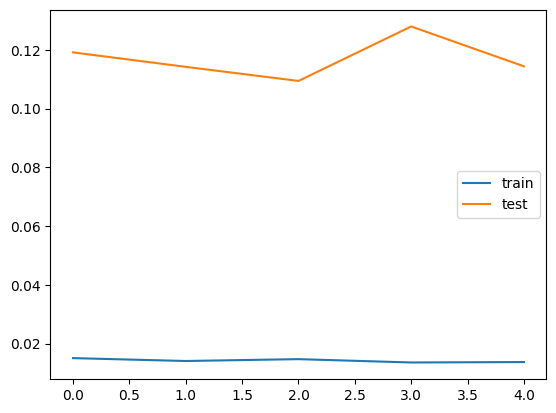

In [21]:
# Affichage des courbes d'apprentissage avec la loss.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Au delà de 5 epochs, le modèle commence à overfitter les données d'entraînement, on a donc choisi de fixer le nombre d'epochs à 5.

## 6. Évaluation du Modèle
Nous évaluons le modèle en calculant le score F1 pour chaque classe et en affichant les matrices de confusion.

In [22]:
# 7. PRÉDICTIONS ET ÉVALUATION
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

998/998 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


F1-Score for toxic: 0.7604
F1-Score for severe_toxic: 0.4098
F1-Score for obscene: 0.7959
F1-Score for threat: 0.3684
F1-Score for insult: 0.7059
F1-Score for identity_hate: 0.5182

F1-Score Macro (moyenne des classes): 0.5931


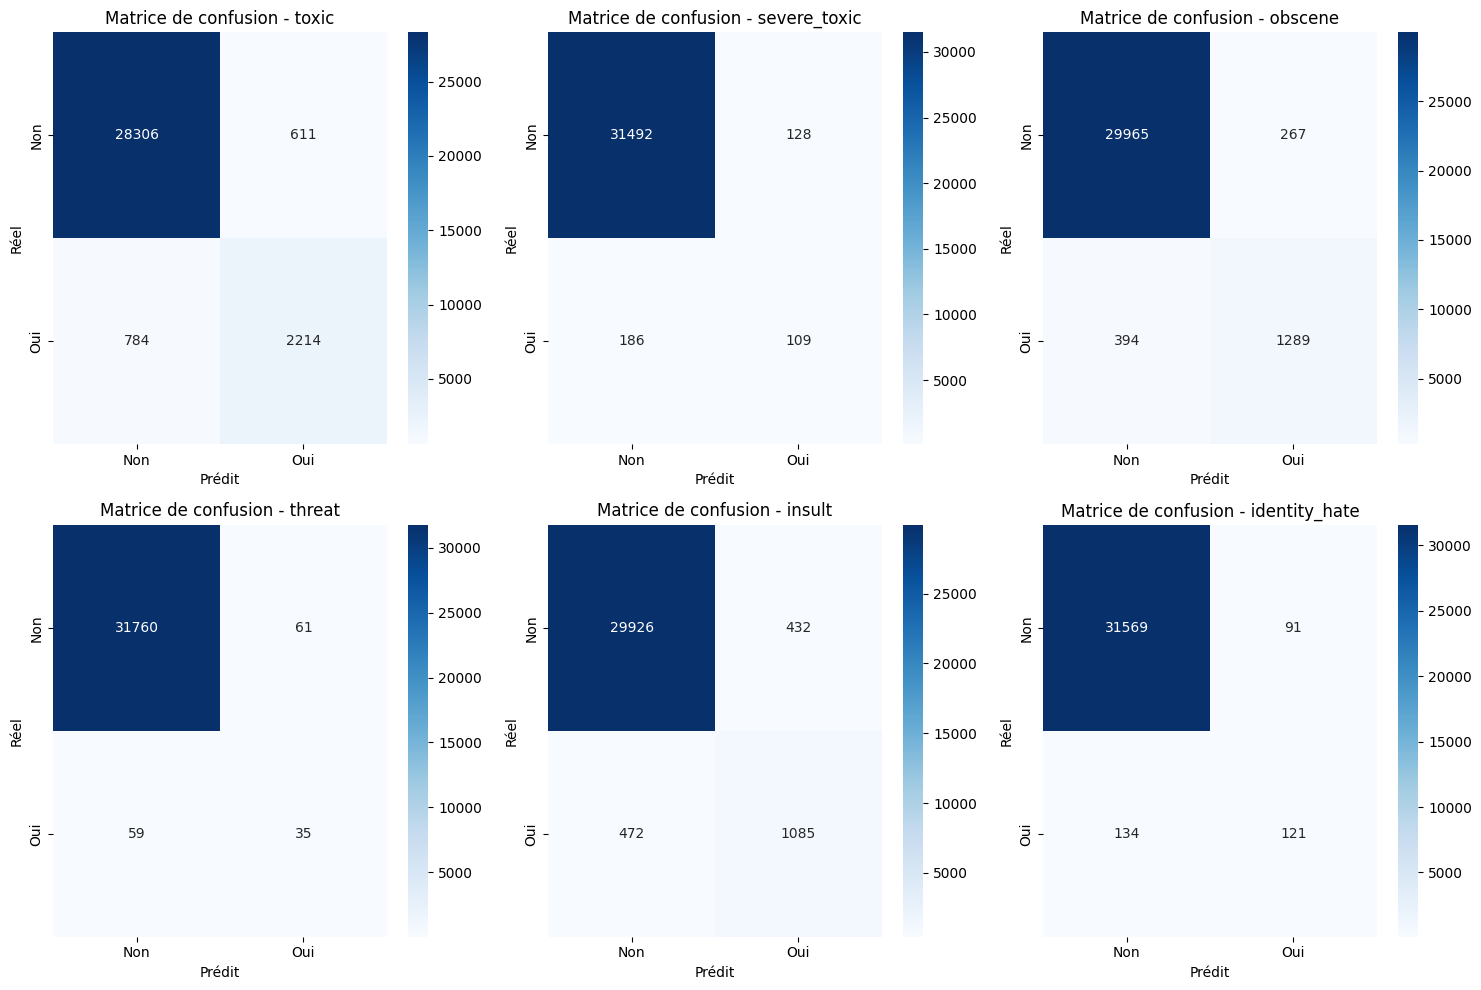

In [ ]:
# F1-Score par classe
f1_scores = f1_score(y_test, y_pred, average=None)
for i, label in enumerate(label_names):
    print(f"F1-Score for {label}: {f1_scores[i]:.4f}")

# Score F1 global (moyenne macro)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"\nF1-Score Macro (moyenne des classes): {f1_macro:.4f}")

# 8. MATRICES DE CONFUSION
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, label in enumerate(label_names):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non", "Oui"], yticklabels=["Non", "Oui"], ax=axes[i])
    axes[i].set_title(f"Matrice de confusion - {label}")
    axes[i].set_xlabel("Prédit")
    axes[i].set_ylabel("Réel")

plt.tight_layout()
plt.show()

Ici les matrices de confusion montrent que le modèle a du mal à prédire les classes minoritaires. Cela est dû au déséquilibre des classes dans les données.

Par contre, elle réussi assez bien à prédire les classes majoritaires comme "toxic", "obscene" et "insult".

## 7. Prédiction avec le Modèle
Comme demandé, on a créé une pipeline pour créer des prédictions à partir de commentaires donnés.

In [ ]:
# 1. Définir une fonction pour effectuer la prédiction
def predict_toxicity(text, tokenizer, model, label_names, max_len=100, threshold=0.5):
    # 1. Prétraitement du texte (tokenisation et padding)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # 2. Prédiction avec le modèle
    y_pred_proba = model.predict(padded_sequence)

    # 3. Appliquer un seuil (threshold) pour les prédictions binaires
    y_pred = (y_pred_proba > threshold).astype(int)

    # 4. Création d'un dictionnaire avec les résultats
    prediction_results = {label: y_pred[0][i] for i, label in enumerate(label_names)}

    # Afficher les résultats des prédictions
    print("Prédictions pour le texte :", text)
    for label, pred in prediction_results.items():
      print(f"{label}: {'Oui' if pred == 1 else 'Non'}")

    # Retourner les résultats
    return prediction_results

In [ ]:
toxic_input = "You are a horrible person!"  # Exemple de texte d'entrée
predictions = predict_toxicity(toxic_input, tokenizer, model, label_names)

In [ ]:
severe_toxic_input = "You are a fucking idiot, I hope you die, mother fucker!"
predictions = predict_toxicity(severe_toxic_input, tokenizer, model, label_names)

In [ ]:
identity_hate_input = "People like you don't belong here, go back to your country. I hate people like you."
predictions = predict_toxicity(identity_hate_input, tokenizer, model, label_names)